In [1]:
import numpy as np
import os
import glob
import allantools
import matplotlib.pyplot as plt
from tqdm import tqdm
import counts_statistics_qpe as cs
import phase_estimation_functions as qpe
from densitymatrix import DM

# import numdifftools as nd
# import numpy.linalg as lg
# import scipy.optimize as sp

In [2]:
"""
GENERATING THE DATA FOR THE ALLAN DEVIATION
"""
def write_stats(contents, filelabels):
    for content, filelabel in zip(contents, filelabels):
        f = open(f"{writting_dir}\\{filelabel}.txt", "w")
        f.write(str(content))
        f.close()

def generate_angles_in_radians(n):
    x = []
    """
    Génère 4 angles aléatoires en radians, chacun étant compris entre 0 et π/2,
    et dont la somme est exactement égale à π/2.
    """
    for i in range(n):
        target_sum = np.pi / 2  # Somme cible
        angles = np.sort(np.random.uniform(-np.pi/2, target_sum, 1))  # Générer 3 points de coupure aléatoires
        
        # Calculer les 4 angles en prenant les différences successives
        a1 = angles[0]
        a2 = target_sum - angles[0]  # Assurer que la somme soit bien égale à π/2

        x.append([a1, a2])
    return x
input_state = 'Plus'
fail_mean = [[0.0019, 0.0176, 0.031],[0.0016, 0.0039, 0.0019],[0.0005, 0.0008, 0.0012],[0.0066, 0.0228, 0.0191]]       
bnds = ((-np.pi/2, np.pi/2),)
x0 = generate_angles_in_radians(20)
for index, file in enumerate(filenames):
    i =3
    n_samples_evol = []
    v = [1 - fail_mean[0][index],1 - fail_mean[1][index],1 - fail_mean[2][index],1 - fail_mean[3][index]]
    bnds = ((0,np.pi),)
    meas_stats = stats_list[f"file_{index+1}"][i]
    estimator_evol = []

    for j in range(3001):
        mle = qpe.Estimator(input_state, i, meas_stats, x0, bnds, "visibility", v[i])
        n_samples_evol.append(j)
        ##### Theta estimation and saving params in dictionary #####
        estimation_results = mle.get_theta(get_cov = True, set_lim = j).x
        estimator_evol.append(np.sum(estimation_results))
        
    writting_dir = f"{data_dir}\{file}\estimation_stats"
    os.makedirs(f"{writting_dir}", exist_ok=True)

    filelabels = ["theta_mle_qubit_3", "n_samples"]
    contents = [estimator_evol, n_samples_evol]
    write_stats(contents, filelabels)

NameError: name 'filenames' is not defined

In [3]:
"""
DEINING FOLDERS AND DIRECTORIES
"""
data_dir = r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\long_QPE_no_Certification"
filenames = [i for i in glob.glob("COMPLETE*")]
os.chdir(data_dir)
n_qubits = 4

stabilizers = ["xxxx"]
stab_sign = [-1]

fail_mean = [[0.0019, 0.0176, 0.031],[0.0016, 0.0039, 0.0019],[0.0005, 0.0008, 0.0012],[0.0066, 0.0228, 0.0191]]

In [24]:
fail_mean

[[0.0019, 0.0176, 0.031],
 [0.0016, 0.0039, 0.0019],
 [0.0005, 0.0008, 0.0012],
 [0.0066, 0.0228, 0.0191]]

In [2]:
"""
CALCULATING THE STATISTICS OBTAINED FROM THE XXXX MEASUREMENTS
"""
n_rounds = 3000
samples_evolution = np.arange(1, n_rounds+1, 1)
stats_list = {"file_1":{}, "file_2":{}, "file_3":{}}
input_state = 'Plus'
p_pass = np.zeros((4, len(filenames), n_rounds))
p_pass_error = np.zeros((4, len(filenames), n_rounds))

for index, file in enumerate(filenames):    
    # pair = 0 refers to top pair and pair = 1 refers to bottom pair
    for pair in range(4):
        STABILIZER_TO_INDEX = {stab: i for i, stab in enumerate(stabilizers)}
        file_dir = f"{data_dir}\{file}\counts"
        os.chdir(file_dir)

        files = [i for i in glob.glob("Phase*.txt")]
        ### This assumes the label is of the form: "PhaseEstimation=xxxx_{index}_{theta_4}"
        files.sort(key = lambda x: int((x.split("_")[2]).split(".")[0]))

        stats = cs.Operartors_Statistics(n_qubits, stabilizers, stab_sign, STABILIZER_TO_INDEX, files, file_dir, input_state, str(pair)) #Set_loops = 1?
        stats_list[f"file_{index+1}"][pair] = stats

        p_pass_list, n_samples_list = stats.get_pass_prob_evolution(samples_evolution)
        
        p_pass[pair][index] = np.array(p_pass_list, dtype = float)
        p_pass_error[pair][index] = np.array(stats.p_pass_error_list, dtype = float)
    
p_fail = 1 - p_pass
p_fail_error = p_pass_error

NameError: name 'filenames' is not defined

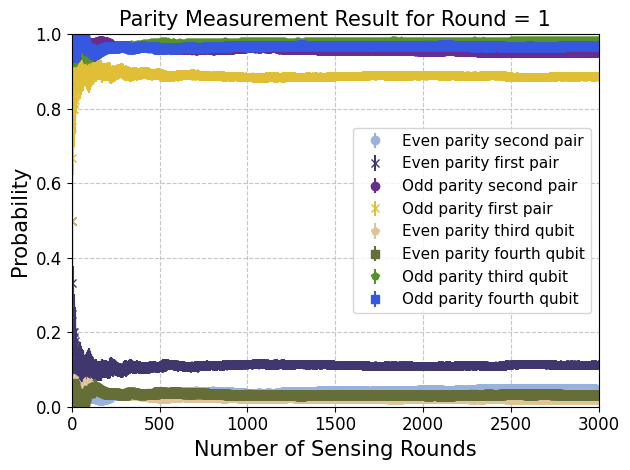

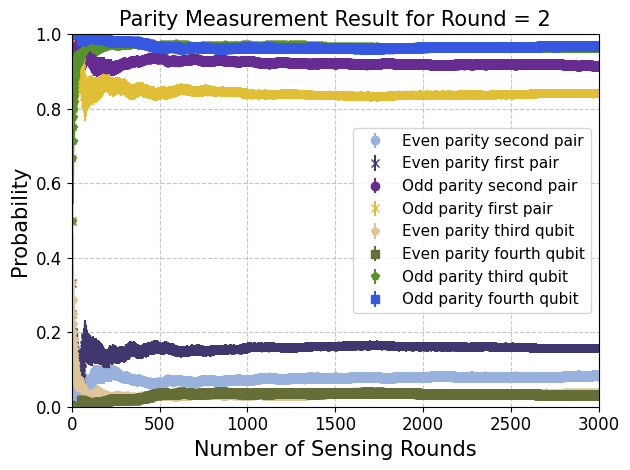

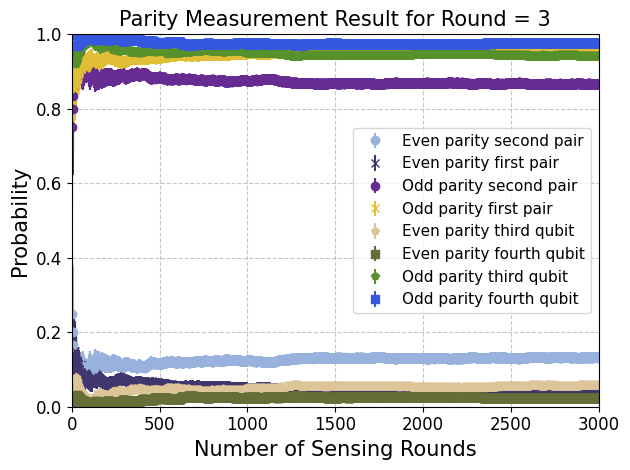

In [36]:
colors = ["#99B2DD","#662C91","#40376E","#E0BE36"]
colors_2 = ['#DDC499','#56912C','#656E37','#3658E0']
for index, file in enumerate(filenames):
    plt.errorbar(samples_evolution, p_pass[0][index], p_pass_error[0][index], color=colors[0], fmt='o', label = "Even parity second pair")
    plt.errorbar(samples_evolution, p_pass[1][index], p_pass_error[1][index], color=colors[2], fmt='x', label = "Even parity first pair")
    plt.errorbar(samples_evolution, p_fail[0][index], p_fail_error[0][index], color=colors[1], fmt='o', label = "Odd parity second pair")
    plt.errorbar(samples_evolution, p_fail[1][index], p_fail_error[1][index], color=colors[3], fmt='x', label = "Odd parity first pair")
    plt.errorbar(samples_evolution, p_pass[2][index], p_pass_error[2][index], color=colors_2[0], fmt='p', label = "Even parity third qubit")
    plt.errorbar(samples_evolution, p_pass[3][index], p_pass_error[3][index], color=colors_2[2], fmt='s', label = "Even parity fourth qubit")
    plt.errorbar(samples_evolution, p_fail[2][index], p_fail_error[2][index], color=colors_2[1], fmt='p', label = "Odd parity third qubit")
    plt.errorbar(samples_evolution, p_fail[3][index], p_fail_error[3][index], color=colors_2[3], fmt='s', label = "Odd parity fourth qubit")


    plt.xlabel("Number of Sensing Rounds", fontsize=15)
    plt.ylabel("Probability", fontsize=15)
    plt.title(f"Parity Measurement Result for Round = {index+1}", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,1)
    plt.xlim(0,3000)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11, markerscale=1.)
    plt.tight_layout()
    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\Long_QPE_no_Certification\Parity_Measurement_Graph\Long_sensing_p_evol_r={index+1}")
    plt.show()

In [ ]:
"""
GENERATING THE DATA FOR THE ALLAN DEVIATION
"""
# def write_stats(contents, filelabels):
#     for content, filelabel in zip(contents, filelabels):
#         f = open(f"{writting_dir}\\{filelabel}.txt", "w")
#         f.write(str(content))
#         f.close()

# for index, file in enumerate(filenames):
#     v = 1 - 2*final_p_fail_mean[index]
#     meas_stats = stats_list[index]

#     estimator_evol = []
#     n_samples_evol = []

#     ##### Theta estimation and saving params in dictionary #####
#     x0 = np.array([np.pi/8, np.pi/8, np.pi/8, np.pi/8])
#     mle = qpe.Estimator(meas_stats, x0, "visibility", v)
    
#     for j in range(5):
#         n_samples_evol.append(j)
        
#         estimation_results = mle.get_theta(get_cov = False, set_lim = j).x
#         estimator_evol.append(np.sum(estimation_results))

#     writting_dir = f"{data_dir}\{file}\estimation_stats_trial"
#     os.makedirs(f"{writting_dir}", exist_ok=True)

#     filelabels = ["theta_mle", "n_samples"]
#     contents = [estimator_evol, n_samples_evol]
#     write_stats(contents, filelabels)

In [78]:
"""
LOADING DATA FOR THE ALLAN DEVIATION
IF THESE FILES WERE NOT GENERATED, YOU CAN USE THE A COMMENTED CELL BELOW TO DO IT
"""
n_configs=6
qtys = ["theta_mle_qubit_2","n_samples"]
theta_mle = {}

for index, file in enumerate(filenames):
    for i in tqdm(range(n_configs)):
        stats_dir = f"{data_dir}\{file}\estimation_stats"
        for qty in qtys:
            with open(f"{stats_dir}\\{qty}.txt", "r") as f:
                # It reads each qtys.txt file and writes its content as variable qtys[i]_list;
                # eg.: p_pass_list and n_samples_list used bellow in the cell are defined here
                var_name = f"{qty}_list"
                locals()[var_name] = list(map(float,list(f.read().strip("[").strip("]").split(","))))
            theta_mle[file] = np.array(theta_mle_qubit_2_list)

100%|██████████| 6/6 [00:00<00:00, 343.59it/s]


The optimal averaging time 1087.0
List of optimal time [1087]


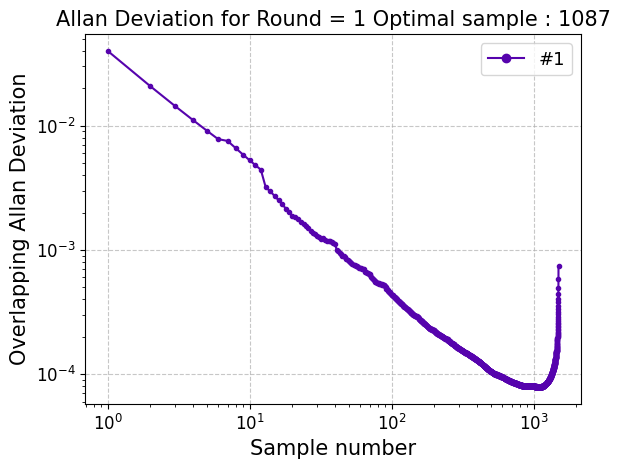

The optimal averaging time 1059.0
List of optimal time [1087, 1031]


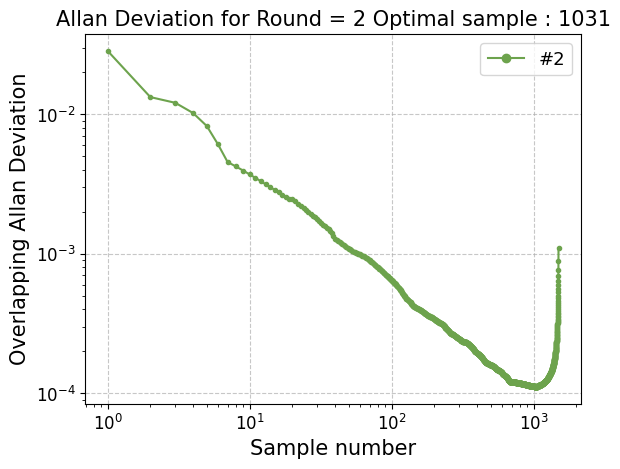

The optimal averaging time 983.3333333333334
List of optimal time [1087, 1031, 832]


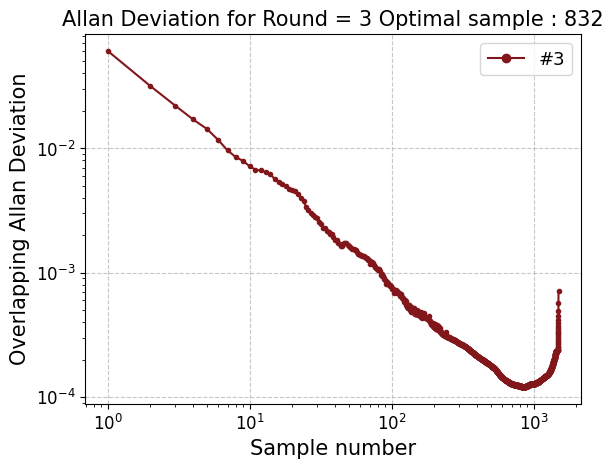

In [79]:
"""
PLOTTING THE ALLAN DEVIATION
"""
def plotallan(plt, y, rate, taus, label, color):
    t2, ad, _, _ = allantools.oadev(y, rate=rate, data_type="phase", taus=taus)
    plt.loglog(t2, ad, color=color, marker=".", label=label)
    return t2, ad

x_min_list = []
colors = ["#5603AD", "#6DA34D", "#81171B", "#F19C79", "#F77F00", "#2274A5"]
taus = np.arange(0, 3001)
for index, file in enumerate(filenames):
    label=f"#{index+1}"
    x_data, y_data = plotallan(plt, np.array(theta_mle[file]), 1, taus , label, color=colors[index])

    y_min = np.min(y_data)
    x_min = list(y_data).index(y_min)
    
    x_min_list.append(x_min)

    x_min_average = np.average(np.array(x_min_list))
    print(f"The optimal averaging time {x_min_average}")
    print(f"List of optimal time {x_min_list}")

    plt.xlabel(r'Sample number', fontsize=15)
    plt.ylabel('Overlapping Allan Deviation', fontsize=15)
    plt.legend(fontsize=13, markerscale=2.)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f"Allan Deviation for Round = {index+1} Optimal sample : {x_min_list[index]}", fontsize=15)
    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\Long_QPE_no_Certification\Allan_Deviation_Graph\Allan_deviation_r={index+1}_0")

    plt.show()

In [ ]:
"""
ESTIMATION OF THETA: WITH THE VISIBILITY AND DENSITY MATRIX METHODS
IT SAVES ALL THE RELEVANT PARAMS IN thetas_mle DICTIONARY
"""
mle = {}
thetas_mle = {0 :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}},
              "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}}},
            1 :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}},
              "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}}},
            2 :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}},
              "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}}},
            3 :{"v": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}},
              "dm": {"sum": {"values": np.zeros(3), "variance": np.zeros(3), "fisher_info": np.zeros(3)},
                    "indiv": {"values": np.zeros((4,3)), "variance": np.zeros((2,3)), "fisher_info": np.zeros((4,3))}}}}

def generate_angles_in_radians(n):
    x = []
    """
    Génère 4 angles aléatoires en radians, chacun étant compris entre 0 et π/2,
    et dont la somme est exactement égale à π/2.
    """
    for i in range(n):
        target_sum = np.pi  # Somme cible
        angles = np.sort(np.random.uniform(-np.pi, target_sum, 1))  # Générer 3 points de coupure aléatoires
        
        # Calculer les 4 angles en prenant les différences successives
        a1 = angles[0]
        a4 = target_sum - angles[0]  # Assurer que la somme soit bien égale à π/2

        x.append(a1)

    return x

def set_estimation_params(estimator_class, dic, index, a_vectors_list):
    mle = estimator_class
    estimation_results = mle.get_theta(get_cov = True, set_lim = None).x

    dic["sum"]["values"][index] = np.array(np.sum(estimation_results))
    dic["sum"]["variance"][index] = np.array(mle.get_variance(np.array([1])))
    dic["sum"]["fisher_info"][index] = np.array(mle.fisher_bound/n_rounds)

### Vector list to extract the estimation of the indifivual params
a_vectors_list = np.array([1])

x0 = generate_angles_in_radians(20)

plus = (np.array([1,0])+np.array([0,1]))/np.sqrt(2)
plusmatrix = np.array(np.outer(plus, np.conjugate(plus)))
fisher_info_matrix_plus = []
dm_folder = [i for i in glob.glob(r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\QST\LONG\Run*")]
QST_file = []
for index, file in enumerate(dm_folder):
    os.chdir(file)
    QST_file.append(glob.glob("QST_*")[0])
density_matrix = {k:{} for k in QST_file}
for index, file in enumerate(dm_folder):
    os.chdir(f'{file}\\{QST_file[index]}')
    with open('density_TOP.npy','rb') as f:
        density_top = np.load(f)
        density_matrix[f'{QST_file[index]}'][0] = qpe.partial_trace(density_top,A=True,B=False)
        density_matrix[f'{QST_file[index]}'][1] = qpe.partial_trace(density_top,A=False,B=True)
    with open('density_BOTTOM.npy','rb') as g:
        density_bottom = np.load(g)
        density_matrix[f'{QST_file[index]}'][2] = qpe.partial_trace(density_bottom,A=True,B=False)
        density_matrix[f'{QST_file[index]}'][3] = qpe.partial_trace(density_bottom,A=False,B=True)
input_state = 'Plus'

for index, file in enumerate(filenames):
    v = [1 - fail_mean[0][index],1 - fail_mean[1][index],1 - fail_mean[2][index],1 - fail_mean[3][index]]
    bnds = ((0,np.pi),)
    for i in range(4):
        dm = density_matrix[f'{QST_file[index]}'][i]
        meas_stats = stats_list[f"file_{index+1}"][i]
        ##### Theta estimation and saving params in dictionary #####
        mle[file] = qpe.Estimator(input_state, i, meas_stats, x0, bnds, "visibility", v[i])
        set_estimation_params(mle[file], thetas_mle[i]["v"], index, a_vectors_list)
        mle[file].set_function_type("density_matrix", dm)
        set_estimation_params(mle[file], thetas_mle[i]["dm"], index, a_vectors_list)
        fisher_info_matrix_plus.append(mle[file].get_cov_matrix())


c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  sub[0][0] = matrixA_B[0][0] + matrixA_B[1][1]
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  sub[0][1] = matrixA_B[0][2] + matrixA_B[1][3]
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  sub[1][0] = matrixA_B[2][0] + matrixA_B[3][1]
c:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Analysis_code\QuantumPhaseEstimation\Laura_test\phase_estimation_functions.py:33: ComplexWarning: Casting complex values to real discards the

In [11]:
print(thetas_mle[0]["v"]["sum"]["values"])
print(thetas_mle[1]["v"]["sum"]["values"])
print(thetas_mle[2]["v"]["sum"]["values"])
print(thetas_mle[3]['v']["sum"]["values"])

NameError: name 'thetas_mle' is not defined

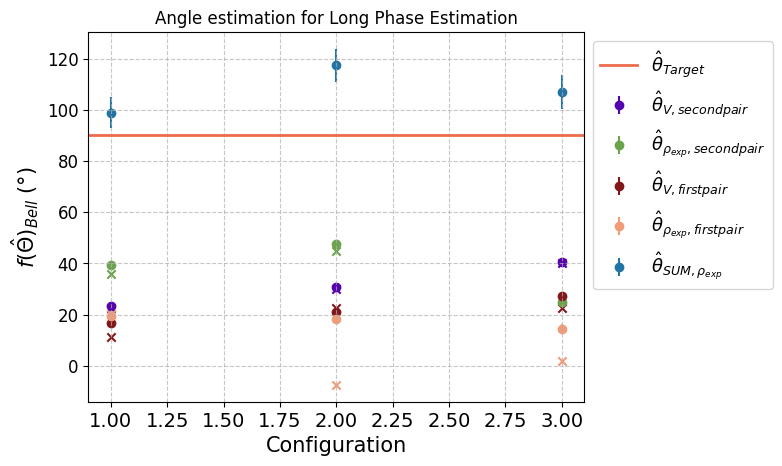

In [53]:
colors = ["#EE6C4D", "#5603AD", "#6DA34D", "#81171B", "#F19C79", "#2274A5"]
x_data = [1, 2, 3]

target_angles = {'RUN_1' : [np.pi/8,np.pi/5,np.pi/16,0.3534291735288517],
                 'RUN_2' : [np.pi/6,np.pi/4,np.pi/8,-0.13089969389957457],
                 'RUN_3' : [2*np.pi/9,np.pi/7,np.pi/8,0.03116659378]}

target_sums = {"0": [(target_angles['RUN_1'][0])*180/np.pi,
                        (target_angles['RUN_2'][0])*180/np.pi,
                        (target_angles['RUN_3'][0])*180/np.pi],
                "1": [(target_angles['RUN_1'][1])*180/np.pi,
                        (target_angles['RUN_2'][1])*180/np.pi,
                        (target_angles['RUN_3'][1])*180/np.pi],
                "2": [(target_angles['RUN_1'][2])*180/np.pi,
                        (target_angles['RUN_2'][2])*180/np.pi,
                        (target_angles['RUN_3'][2])*180/np.pi],
                "3": [(target_angles['RUN_1'][3])*180/np.pi,
                        (target_angles['RUN_2'][3])*180/np.pi,
                        (target_angles['RUN_3'][3])*180/np.pi]}

plt.figure(figsize=(6.4, 4.8))
plt.errorbar(x_data, (thetas_mle[0]["v"]["sum"]["values"])*180/np.pi,thetas_mle[0]["v"]["sum"]["variance"]*180/np.pi, color=colors[1], label = r"$\hat{\theta}_{V,second pair}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[1]["v"]["sum"]["values"]*180/np.pi,thetas_mle[1]["v"]["sum"]["variance"]*180/np.pi, color=colors[2], label = r"$\hat{\theta}_{\rho_{exp},second pair}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[2]["v"]["sum"]["values"]*180/np.pi,thetas_mle[2]["v"]["sum"]["variance"]*180/np.pi, color=colors[3], label = r"$\hat{\theta}_{V,first pair}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[3]["v"]["sum"]["values"]*180/np.pi,thetas_mle[3]["v"]["sum"]["variance"]*180/np.pi, color=colors[4], label = r"$\hat{\theta}_{\rho_{exp},first pair}$", marker = 'o', linestyle = "",zorder=1)

plt.errorbar(x_data, (thetas_mle[0]["v"]["sum"]["values"]+thetas_mle[1]["v"]["sum"]["values"]+thetas_mle[2]["v"]["sum"]["values"]+thetas_mle[3]["v"]["sum"]["values"])*180/np.pi,(thetas_mle[1]["v"]["sum"]["variance"]+thetas_mle[0]["v"]["sum"]["variance"]+thetas_mle[2]["v"]["sum"]["variance"]+thetas_mle[3]["v"]["sum"]["variance"])*180/np.pi, color=colors[5], label = r"$\hat{\theta}_{SUM,\rho_{exp}}$", marker = 'o', linestyle = "",zorder=1)
plt.axhline(np.pi/2*180/np.pi, color=colors[0], linestyle='-', label=r"$\hat{\theta}_{Target}$", linewidth=2)
for i in range((len(target_sums))):
    plt.scatter(x_data,target_sums[str(i)],marker='x',color = colors[i+1],zorder=0)


plt.xlabel("Configuration", fontsize=15)
plt.ylabel(r"$f(\hat{\Theta})_{Bell}$ (°)", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
plt.legend(fontsize=13, markerscale=1.,loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Angle estimation for Long Phase Estimation")
plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\long_QPE_no_Certification\Angle_Long_Phase_Estimation_visibility", bbox_inches='tight')
plt.show()

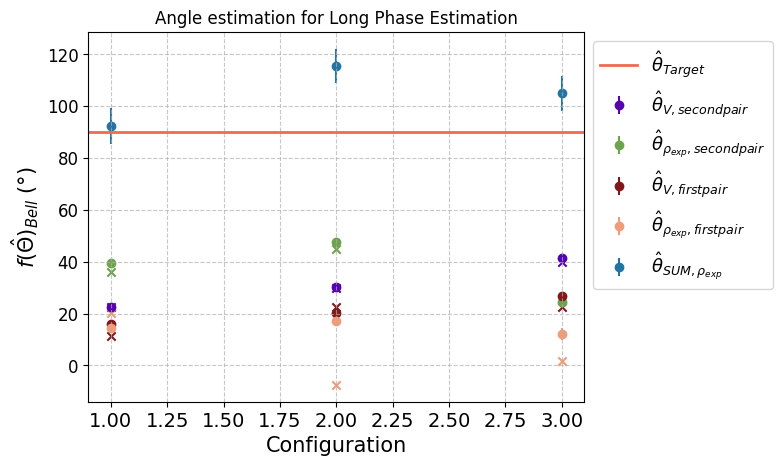

In [54]:
colors = ["#EE6C4D", "#5603AD", "#6DA34D", "#81171B", "#F19C79", "#2274A5"]
x_data = [1, 2, 3]

target_angles = {'RUN_1' : [np.pi/8,np.pi/5,np.pi/16,0.3534291735288517],
                 'RUN_2' : [np.pi/6,np.pi/4,np.pi/8,-0.13089969389957457],
                 'RUN_3' : [2*np.pi/9,np.pi/7,np.pi/8,0.03116659378]}

target_sums = {"0": [(target_angles['RUN_1'][0])*180/np.pi,
                        (target_angles['RUN_2'][0])*180/np.pi,
                        (target_angles['RUN_3'][0])*180/np.pi],
                "1": [(target_angles['RUN_1'][1])*180/np.pi,
                        (target_angles['RUN_2'][1])*180/np.pi,
                        (target_angles['RUN_3'][1])*180/np.pi],
                "2": [(target_angles['RUN_1'][2])*180/np.pi,
                        (target_angles['RUN_2'][2])*180/np.pi,
                        (target_angles['RUN_3'][2])*180/np.pi],
                "3": [(target_angles['RUN_1'][3])*180/np.pi,
                        (target_angles['RUN_2'][3])*180/np.pi,
                        (target_angles['RUN_3'][3])*180/np.pi]}

plt.figure(figsize=(6.4, 4.8))
plt.errorbar(x_data, thetas_mle[0]["dm"]["sum"]["values"]*180/np.pi,thetas_mle[0]["dm"]["sum"]["variance"]*180/np.pi, color=colors[1], label = r"$\hat{\theta}_{V,second pair}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[1]["dm"]["sum"]["values"]*180/np.pi,thetas_mle[1]["dm"]["sum"]["variance"]*180/np.pi, color=colors[2], label = r"$\hat{\theta}_{\rho_{exp},second pair}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[2]["dm"]["sum"]["values"]*180/np.pi,thetas_mle[2]["dm"]["sum"]["variance"]*180/np.pi, color=colors[3], label = r"$\hat{\theta}_{V,first pair}$", marker = 'o', linestyle = "",zorder=1)
plt.errorbar(x_data, thetas_mle[3]["dm"]["sum"]["values"]*180/np.pi,thetas_mle[3]["dm"]["sum"]["variance"]*180/np.pi, color=colors[4], label = r"$\hat{\theta}_{\rho_{exp},first pair}$", marker = 'o', linestyle = "",zorder=1)

plt.errorbar(x_data, (thetas_mle[0]["dm"]["sum"]["values"]+thetas_mle[1]["dm"]["sum"]["values"]+thetas_mle[2]["dm"]["sum"]["values"]+thetas_mle[3]["dm"]["sum"]["values"])*180/np.pi,(thetas_mle[1]["dm"]["sum"]["variance"]+thetas_mle[0]["dm"]["sum"]["variance"]+thetas_mle[2]["dm"]["sum"]["variance"]+thetas_mle[3]["dm"]["sum"]["variance"])*180/np.pi, color=colors[5], label = r"$\hat{\theta}_{SUM,\rho_{exp}}$", marker = 'o', linestyle = "",zorder=1)
plt.axhline(np.pi/2*180/np.pi, color=colors[0], linestyle='-', label=r"$\hat{\theta}_{Target}$", linewidth=2)
for i in range((len(target_sums))):
    plt.scatter(x_data,target_sums[str(i)],marker='x',color = colors[i+1],zorder=0)


plt.xlabel("Configuration", fontsize=15)
plt.ylabel(r"$f(\hat{\Theta})_{Bell}$ (°)", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
plt.legend(fontsize=13, markerscale=1.,loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Angle estimation for Long Phase Estimation")
plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\long_QPE_no_Certification\Angle_Long_Phase_Estimatio_dm", bbox_inches='tight')
plt.show()

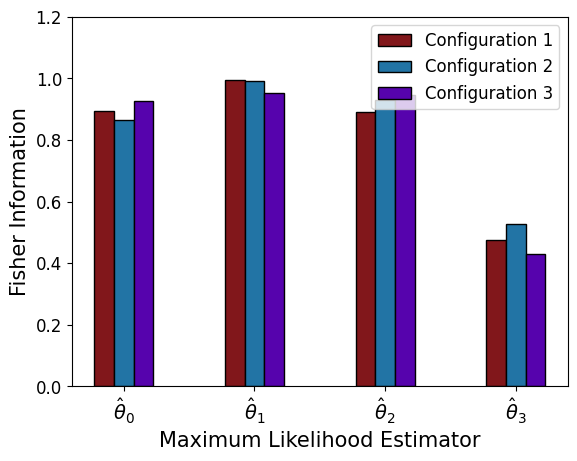

In [39]:
"""
PLOTTING THE FISHER INFORMATION FOR THE EACH OF THE a_vectors DEFINED ABOVE
"""
def plot_histogram(data, labels, colors, bar_width=0.15, ylim=None):
    num_groups = len(data[0])  # Assuming all datasets have the same number of x-axis groups
    num_datasets = len(data)
    x = np.arange(num_groups)  # X-axis positions for the first dataset
    
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    
    for i in range(num_datasets):
        ax.bar(x + i * bar_width, data[i], width=bar_width, label=labels[i], color=colors[i], edgecolor='black')
    
    ax.set_xticks(x + (num_datasets - 1) * bar_width / 2)
    ax.set_xticklabels([r'$\hat{\theta}_{0}$', r'$\hat{\theta}_{1}$', r'$\hat{\theta}_{2}$', r'$\hat{\theta}_{3}$'], fontsize=14)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Maximum Likelihood Estimator", fontsize = 15)
    ax.set_ylabel("Fisher Information", fontsize = 15)

    # ax.set_title("Histogram with Multiple Data Sets")
    ax.legend(fontsize=12)
    
    if ylim:
        ax.set_ylim(0, ylim)

    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\Long_QPE_no_Certification\Fisher_Information")
    plt.show()

# Example data for 6 datasets, each having values for 5 groups
data = [
    thetas_mle[0]["dm"]["sum"]["fisher_info"],
    thetas_mle[1]["dm"]["sum"]["fisher_info"],
    thetas_mle[2]["dm"]["sum"]["fisher_info"],
    thetas_mle[3]["dm"]["sum"]["fisher_info"]
]

data=np.transpose(data)
labels = ["Configuration 1", "Configuration 2", "Configuration 3"]
colors = ["#81171B", "#2274A5", "#5603AD", "#F19C79", "#F77F00", "#6DA34D"]

plot_histogram(data, labels, colors, ylim=1.2)


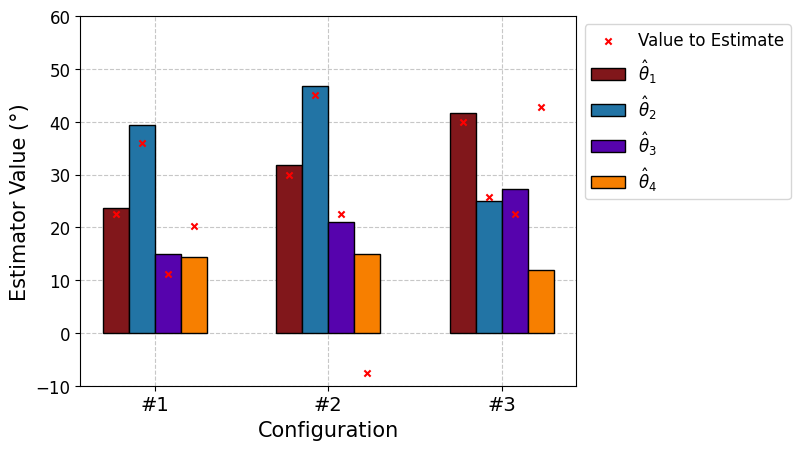

In [42]:
import matplotlib.pyplot as plt
import numpy as np

os.chdir(r'C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\QST\Long_QPE_no_Certification')
folder = [i for i in glob.glob(r"Run*")]



Angles = {'RUN_1' : [np.pi/8,np.pi/5,np.pi/16,0.3534291735288517],'RUN_2' : [np.pi/6,np.pi/4,np.pi/8,-0.13089969389957457],
          'RUN_3' : [2*np.pi/9,np.pi/7,np.pi/8,0.7476646259971648],'RUN_4' : [0,np.pi/6,np.pi/5,0.41887902047863923],
          'RUN_5' : [np.pi/16,np.pi/10,np.pi/12,0.7984881327874058],'RUN_6' : [np.pi/20,np.pi/16,np.pi/19,1.052020171498161]}

def plot_histogram(data, labels, colors, bar_width=0.15, ylim=None):
    num_groups = len(data[0])  # Assuming all datasets have the same number of x-axis groups
    num_datasets = len(data)
    x = np.arange(num_groups)  # X-axis positions for the first dataset
    
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    
    for i in range(num_datasets):
        ax.bar(x + i * bar_width, data[i], width=bar_width, label=labels[i], color=colors[i], edgecolor='black')

    
    legend_added = False  # Variable pour éviter de répéter la légende

    for i in range(num_groups):
            for w in range(num_datasets):
                x_point = x[i] + w * bar_width
                y_point = Angles[str(folder[i])][w] * 180 / np.pi

                if not legend_added:  # Ajouter la légende une seule fois
                    ax.scatter(x_point, y_point, color='red', s=20, marker="x", label='Value to Estimate')
                    legend_added = True
                else:
                    ax.scatter(x_point, y_point, color='red', s=20, marker="x")
            

    ax.set_xticks(x + (num_datasets - 1) * bar_width / 2)
    ax.set_xticklabels(['#1', '#2', '#3'], fontsize=14)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_xlabel("Configuration", fontsize = 15)
    ax.set_ylabel("Estimator Value (°)", fontsize = 15)

    # ax.set_title("Histogram with Multiple Data Sets")
    ax.legend(fontsize=12, bbox_to_anchor=(1, 1))

    
    if ylim:
        ax.set_ylim(-10, ylim)
    
    ax.set_axisbelow(True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Plus\Long_QPE_no_Certification\Estimator_Value_Plus",bbox_inches='tight')
    plt.show()

# Example data for 6 datasets, each having values for 5 groups
data = [
    thetas_mle[0]["dm"]["sum"]["values"]*180/np.pi,
    thetas_mle[1]["dm"]["sum"]["values"]*180/np.pi,
    thetas_mle[2]["dm"]["sum"]["values"]*180/np.pi,
    thetas_mle[3]["dm"]["sum"]["values"]*180/np.pi
]

# data=np.transpose(data)
labels = [r"$\hat{\theta}_1$", r"$\hat{\theta}_2$", r"$\hat{\theta}_3$", r"$\hat{\theta}_4$"]
colors = ["#81171B", "#2274A5", "#5603AD", "#F77F00", "#6DA34D"]

plot_histogram(data, labels, colors, ylim=60)

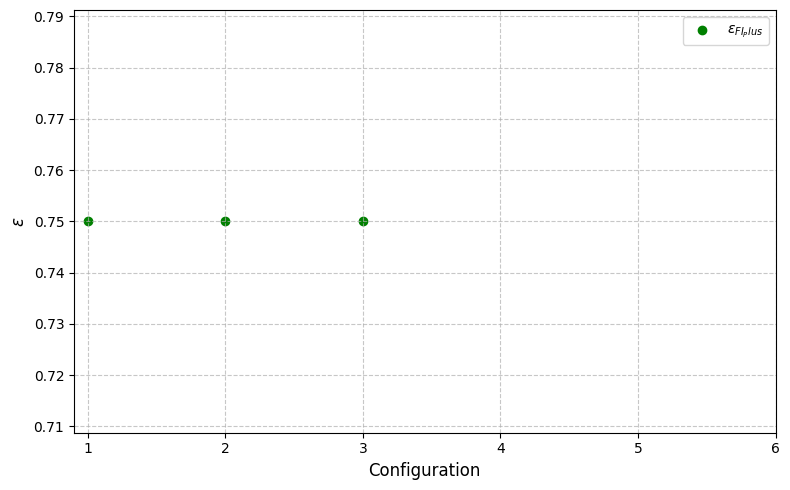

In [73]:
'''PRIVACY PLOT '''
import csv


def privacy(state,a_vector,fisher_info_matrix,fisher_info_matrix2=None,fisher_info_matrix3=None,fisher_info_matrix4=None):
    if state =='GHZ':
        return np.trace((np.identity(4)-((np.transpose(a_vector)*a_vector)/(np.linalg.norm(a_vector))**2))@fisher_info_matrix)/np.trace(fisher_info_matrix)

    if state == 'Bell':
        fisher_info_matrix_combine = np.block([[fisher_info_matrix,np.zeros((2, 2))],[np.zero((2, 2)),fisher_info_matrix2]])
        return np.trace((np.identity(4)-((np.transpose(a_vector)*a_vector)/(np.linalg.norm(a_vector))**2))@fisher_info_matrix_combine)/(np.trace(fisher_info_matrix_combine))
    
    if state == 'Plus':
        fisher_info_matrix_combine = np.block([[fisher_info_matrix,np.zeros((1,1)),np.zeros((1, 1)),np.zeros((1,1))],
                                               [np.zeros((1,1)),fisher_info_matrix2,np.zeros((1, 1)),np.zeros((1,1))],
                                               [np.zeros((1,1)),np.zeros((1,1)),fisher_info_matrix3,np.zeros((1,1))],
                                               [np.zeros((1,1)),np.zeros((1,1)),np.zeros((1, 1)),fisher_info_matrix4]])
        return np.trace((np.identity(4)-((np.transpose(a_vector)*a_vector)/(np.linalg.norm(a_vector))**2))@fisher_info_matrix_combine)/(np.trace(fisher_info_matrix_combine))

        
    
epsilon_GHZ = []
epsilon_Bell = []
epsilon_Plus = []
Fidelity_privacy_GHZ = []
Fidelity_privacy_Bell = []

#Fidelity_GHZ = [i for i in glob.glob(r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Verif\GHZ*")]
#Fidelity_Bell = [i for i in glob.glob(r"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\Verif\Bell*")]

#for files in Fidelity_GHZ:
    #with open(files, 'r') as output:
        #Fidelity_privacy_GHZ.append(1-sum(np.loadtxt(output, comments="#", delimiter=",", unpack=False))/30)

#for files in Fidelity_Bell:
    #with open(files, 'r') as output:
        #Fidelity_privacy_Bell.append(1-(sum(np.loadtxt(output, comments="#", delimiter=",", unpack=False))/30))

# for i in range(len(fisher_info_matrix_GHZ)):
#     state = 'GHZ'
#     a_vector = np.matrix([1, 1, 1, 1])
#     epsilon_GHZ.append(privacy(state,a_vector,fisher_info_matrix_GHZ[i]))


# for i in range((3)):
#     state = 'Bell'
#     a_vector = np.matrix([1, 1, 1, 1])
#     epsilon_Bell.append(privacy(state,a_vector,fisher_info_matrix_bell[i*2],fisher_info_matrix_bell[(i*2)+1]))

for i in range((3)):
    state = 'Plus'
    a_vector = np.matrix([1, 1, 1, 1])
    epsilon_Plus.append(privacy(state,a_vector,fisher_info_matrix_plus[3*i],fisher_info_matrix_plus[3*i+1],fisher_info_matrix_plus[3*i+2],fisher_info_matrix_plus[3*i+3]))

x_vals = [1, 2, 3, 4, 5, 6]
x_vals2 = [1, 2, 3]
plt.figure(figsize=(8, 5))
# plt.scatter(x_vals, epsilon_GHZ, marker='o', linestyle='-', color='blue',label = r"$\epsilon_{FI\_GHZ}$")
# plt.scatter(x_vals,Fidelity_privacy_GHZ, marker='o', linestyle='-', color='red',label = r'$\epsilon_{Fidelity\_GHZ}$')
plt.scatter(x_vals2, epsilon_Plus, marker='o', linestyle='-', color='green',label=r'$\epsilon_{FI_Plus}$')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel(r'$\epsilon$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_vals)
plt.tight_layout()
plt.legend()
plt.savefig(rf"C:\Users\QILIP6\Desktop\Multipartite Entanglement Experiment\Data\FOR PUBLICATION\Private_QPE_paper\GHZ\Long_QPE_no_Certification\Privacy_GHZ.pdf", bbox_inches='tight')
plt.show()

In [74]:
epsilon_Plus

[0.75, 0.75, 0.7499999999999999]

In [ ]:
# ############## Estimation with the inversion of the likelihood function #################
# theta_inverse_list = []
# theta_inv_error_list = []

# hessian_matrix_list = []
# fisher_info_list = []

# x_data = [1, 2, 3, 4, 5, 6]

# for index, file in enumerate(filenames):
#     v = 1 - final_p_fail_mean[index]

#     # Compute inverse probability
#     theta_inverse, theta_inv_error = qpe.get_theta(p_pass[index][-1], v, p_pass_error[index][-1], final_p_fail_error_mean[index])
#     theta_inverse_list.append(theta_inverse)
#     theta_inv_error_list.append(theta_inv_error)

# theta_inverse_all = np.array(theta_inverse_list, dtype = float)

# theta_inv_error_all = np.array(theta_inv_error_list, dtype = float)
# theta_mean = np.average(theta_inverse_all)

# # Plot results
# plt.errorbar(x_data, theta_inverse_all*180/np.pi, theta_inv_error_all*180/np.pi, label="Theta inv", marker='o', linestyle="")

# # plt.axhline(theta_mean*180/np.pi, color='blue', linestyle='--', label=f"Mean theta ({180/np.pi*theta_mean:.2f}°)")
# plt.axhline(np.pi/2*180/np.pi, color='red', linestyle='-', label=f"Target theta")


# plt.xlabel("Round")
# plt.ylabel("Theta (°)")
# plt.ylim(0, 105)
# plt.title("Parameter Estimation")
# plt.legend()
# plt.grid(True)
# plt.show()